<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/v0/shot0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# workflow notebook

Used reference:
-  [git in colab](https://www.geeksforgeeks.org/how-to-install-and-use-git-in-google-colab/)!

# 0. Open ipynb from github
To get this latest notebook from our repo into colab:
> "Open in colab" button == {Download from github} + {Upload to colab} - {Gets saved to drive}

# 1. Set up project in runtime
The following cell runs git config, clones the repo to get datasets as runtime files, and cds into project directory.

In [11]:
!git config –global user.email “h.stuart.livingstone@gmail.com”
!git config –global user.name “StuartLiv”
!git clone https://your_token@github.com/StuartLiv/CPSC-440-Project.git

fatal: not in a git directory
fatal: not in a git directory
fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.


In [12]:
%pwd

'/content'

`git clone` seems too good to be true for getting a few GB of data into runtime, but `/datasets/` is up once clone is run! See:

In [13]:
import os
path = '/content/CPSC-440-Project/datasets/smallset_onesize/color'
files = os.listdir(path)
print(files)

['6476.jpg', '4439.jpg', '3161.jpg', '1868.jpg', '4623.jpg', '1114.jpg', '1052.jpg', '727.jpg', '5571.jpg', '3310.jpg', '3351.jpg', '4793.jpg', '1734.jpg', '6407.jpg', '3185.jpg', '6808.jpg', '3042.jpg', '3974.jpg', '7044.jpg', '44.jpg', '2615.jpg', '5358.jpg', '5703.jpg', '3784.jpg', '1406.jpg', '3622.jpg', '6020.jpg', '433.jpg', '4091.jpg', '5259.jpg', '5778.jpg', '3594.jpg', '2757.jpg', '3698.jpg', '5374.jpg', '2789.jpg', '4838.jpg', '1794.jpg', '2764.jpg', '6024.jpg', '726.jpg', '4516.jpg', '6241.jpg', '3797.jpg', '6570.jpg', '1675.jpg', '5518.jpg', '3309.jpg', '6775.jpg', '527.jpg', '1231.jpg', '3932.jpg', '6058.jpg', '6034.jpg', '5774.jpg', '3625.jpg', '3533.jpg', '4357.jpg', '1767.jpg', '1150.jpg', '311.jpg', '5715.jpg', '5680.jpg', '980.jpg', '1067.jpg', '6418.jpg', '5953.jpg', '882.jpg', '1262.jpg', '1535.jpg', '1692.jpg', '3661.jpg', '6758.jpg', '5642.jpg', '5061.jpg', '1384.jpg', '1182.jpg', '4944.jpg', '2996.jpg', '6600.jpg', '828.jpg', '1746.jpg', '3863.jpg', '4999.jpg', '

# 2. Preprocess data

Datasets:
- `smallset_onesize`
  - Downloaded as is, [here](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization).
  - 7130 color/gray pairs
  - Res 150x150
  - 0.232GB

In [14]:
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
import cv2 as cv


''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = cv.imread(path + '/'+i,1)
    img = img.astype('float32') / 255.0
    arr.append(img_to_array(img))

  return arr


In [15]:
color_arr = make_image_arr('/content/CPSC-440-Project/datasets/smallset_onesize/color')

100%|██████████| 7129/7129 [00:07<00:00, 928.06it/s]


In [16]:
gray_arr = make_image_arr('/content/CPSC-440-Project/datasets/smallset_onesize/gray')

100%|██████████| 7129/7129 [00:06<00:00, 1028.70it/s]


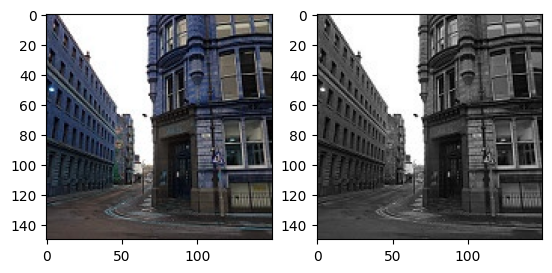

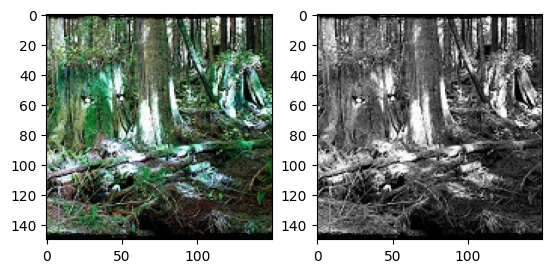

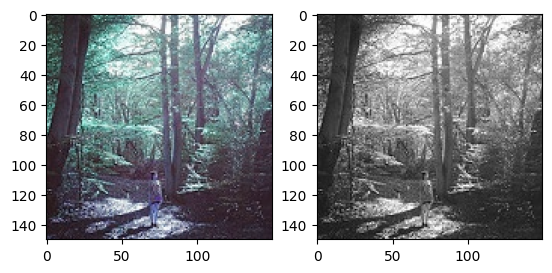

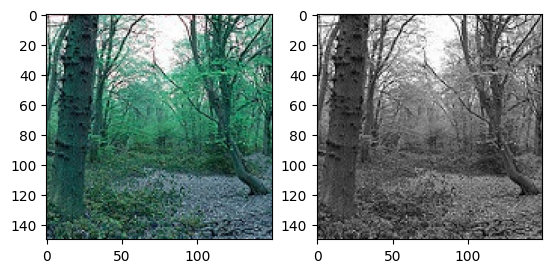

In [17]:
import matplotlib.pyplot as plt
import numpy as np

for i in np.random.randint(len(color_arr),size=4):
  plt.subplot(1,2,1)
  plt.imshow(color_arr[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_arr[i])
  plt.show()

# 3. Saving new model weights to project directory

Toy model generated below:

- does not take our shapes (generator give it `image = torch.randn(1, 3, 224, 224)` :P)
- untrainable but just save it

In [18]:
# prompt: pytorch colourization autoencoder

import torch
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
# Create the autoencoder
autoencoder = Autoencoder()



input.shape (150, 150, 3)


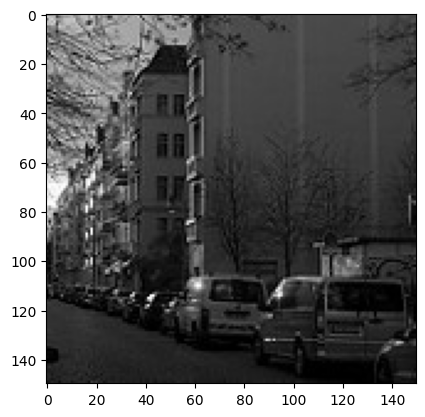

In [23]:
# Load the image
image = gray_arr[0]
print(f'input.shape {image.shape}')
# Colorize the image
plt.imshow(image)
t = torch.from_numpy(np.moveaxis(image, [2, 1], [0,2]))
colorized_image = autoencoder(t)
colorized_image_format = np.moveaxis(colorized_image.detach().numpy(), [1,2], [0,1])
#plt.imshow(colorized_image_format)

#Shows the axis swap is correct process:
#plt.imshow(np.moveaxis(np.moveaxis(image, [2,1], [0,2]), [1,2], [0,1]))

In [ ]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/v0/decoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
!git add .

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   v0/decoder_weights



In [ ]:
!git commit -m "Message here"

In [ ]:
!git push

# 5. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!